# Graded assignment 1 - text classification using Genetic Algorithms
## By Abdullah Karagøz

In this assignmetn we'll make a binary text classifier using genetic algorithms. We will classify movie reviews from IMDB as either negative or positive. This task consists of several steps:

1. Preprocessing of the text
2. Genetich Algorithm
3. Validation



## 1. Preprocessing

### 1.1 Uploading data

In [430]:
## Upload the text
import numpy as np
import pandas as pd
import nltk
import string
import re
import math
import random
from scipy import special
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [431]:
# File directories
corpus_train_pos_root = 'aclImdb/train/pos/'
corpus_train_neg_root = 'aclImdb/train/neg/'
corpus_test_pos_root = 'aclImdb/test/pos/'
corpus_test_neg_root = 'aclImdb/test/neg/'

# Corpus file objects
files_train_pos = PlaintextCorpusReader(corpus_train_pos_root, '.*')
files_train_neg = PlaintextCorpusReader(corpus_train_neg_root, '.*')
files_test_pos = PlaintextCorpusReader(corpus_test_pos_root, '.*')
files_test_neg = PlaintextCorpusReader(corpus_test_neg_root, '.*')


# Getting review texts, labels and rates all in arrays
# Here we save the labels as one hot encoded arrays so it's easier to make
# calculations in the classifier easier.
reviews_train_pos = [files_train_pos.open(n).read() for n in files_train_pos.fileids()]
rates_train_pos = [int(re.split("_|\.", n)[-2]) for n in files_train_pos.fileids()]
labels_train_pos = [1] * len(reviews_train_pos)

reviews_train_neg = [files_train_neg.open(n).read() for n in files_train_neg.fileids()]
rates_train_neg = [int(re.split("_|\.", n)[-2]) for n in files_train_neg.fileids()]
labels_train_neg = [0] * len(reviews_train_neg)

reviews_test_pos = [files_test_pos.open(n).read() for n in files_test_pos.fileids()]
rates_test_pos = [int(re.split("_|\.", n)[-2]) for n in files_test_pos.fileids()]
labels_test_pos = [1] * len(reviews_test_pos)

reviews_test_neg = [files_test_neg.open(n).read() for n in files_test_neg.fileids()]
rates_test_neg = [int(re.split("_|\.", n)[-2]) for n in files_test_neg.fileids()]
labels_test_neg = [0] * len(reviews_test_neg)

### 1.2 Splitting data

In [432]:
# Putting all into two Pandas dataframes - training set and testing set
train_set = pd.DataFrame()
test_set = pd.DataFrame()
valid_set = pd.DataFrame()
whole_set = pd.DataFrame()



whole_set['review'] = reviews_train_pos + reviews_test_pos + reviews_train_neg + reviews_test_neg
whole_set['rate'] = rates_train_pos + rates_test_pos + rates_train_neg + rates_test_neg
whole_set['label'] = labels_train_pos + labels_test_pos + labels_train_neg + labels_test_neg

negatives = whole_set.loc[whole_set['label'] == 0]
positives = whole_set.loc[whole_set['label'] == 1]

tr_neg, vl_neg, ts_neg = np.split(negatives, [int(0.7*len(negatives)), int(0.85*len(negatives))])

train_set, valid_set, test_set = np.split(positives, [int(0.7*len(positives)), int(0.85*len(positives))])

train_set = train_set.append(tr_neg)
valid_set = valid_set.append(vl_neg)
test_set = test_set.append(ts_neg)

train_set.reset_index(inplace=True, drop=True)
valid_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)


# train_set_neg, valid_set_neg, test_set_neg = np.split(whole_set.loc[whole_set['label'] == 0


# train_set['review'] = reviews_train_pos + reviews_train_neg
# train_set['rate'] = rates_train_pos + rates_train_neg
# train_set['label'] = labels_train_pos + labels_train_neg

# negs_cut = int(len(labels_test_neg)/2)
# poss_cut = int(len(labels_test_pos)/2)

# test_set['review'] = reviews_test_pos[:poss_cut] + reviews_test_neg[:negs_cut]
# test_set['rate'] = rates_test_pos[:poss_cut] + rates_test_neg[:negs_cut]
# test_set['label'] = labels_test_pos[:poss_cut] + labels_test_neg[:negs_cut]

# valid_set['review'] = reviews_test_pos[poss_cut:] + reviews_test_neg[negs_cut:]
# valid_set['rate'] = rates_test_pos[poss_cut:] + rates_test_neg[negs_cut:]
# valid_set['label'] = labels_test_pos[poss_cut:] + labels_test_neg[negs_cut:]

### 1.3 Data exploration

In [433]:
len(train_set)

35000

In [434]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set["review"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(20))
print("\nMost common 20 counted by word count total: ", cnt.most_common(20))

# print("Least common 20 counted by appearance in nr of reviews: ", cnt2.most_common()[:-20])
# print("\nLeast common 20 counted by word count total: ", cnt.most_common()[:-20])



Most common 20 counted by appearance in nr of reviews:  [('the', 34512), ('a', 33657), ('and', 33527), ('of', 33109), ('to', 32761), ('is', 31043), ('in', 30224), ('this', 29017), ('that', 27272), ('it', 26552), ('I', 25151), ('for', 24184), ('with', 23784), ('but', 22444), ('was', 22333), ('The', 21788), ('as', 21391), ('on', 20873), ('/><br', 20460), ('have', 19648)]

Most common 20 counted by word count total:  [('the', 398431), ('a', 215543), ('and', 211791), ('of', 198887), ('to', 183609), ('is', 142852), ('in', 119064), ('I', 92383), ('that', 89328), ('this', 79871), ('it', 75658), ('/><br', 71081), ('was', 64813), ('as', 58564), ('with', 57992), ('for', 56780), ('The', 46966), ('but', 46488), ('on', 42896), ('movie', 42730)]


Text(0, 0.5, '% of documents')

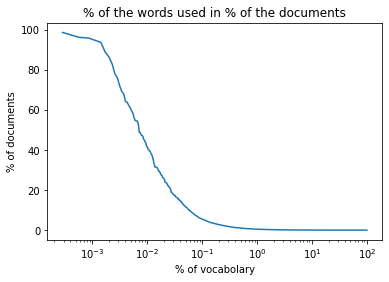

In [435]:
# What % of the reviews use what % of the vocab
vocab_size = len(cnt2)
sample_size = len(train_set)

y = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
x = [c/vocab_size * 100 for c in range(1, vocab_size+1)]
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")

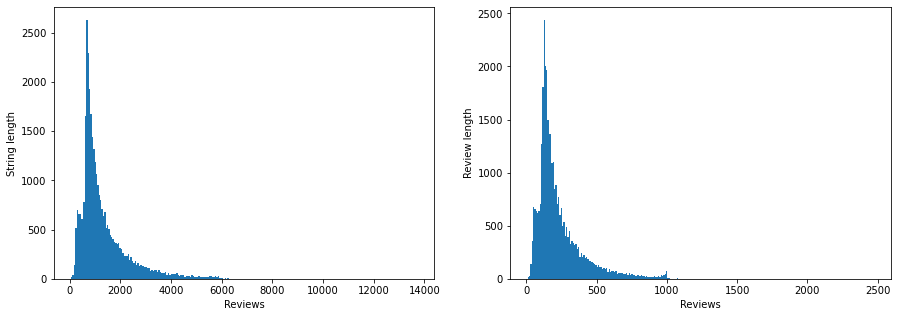

In [436]:
# Length distribution of the reviews
train_set['rev_lens_raw'] = train_set['review'].str.len()
train_set['rev_lens_words'] = train_set['review'].str.split().apply(len)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(train_set['rev_lens_raw'], bins='auto')
ax[0].set_xlabel("Reviews")
ax[0].set_ylabel("String length")
ax[1].hist(train_set['rev_lens_words'], bins='auto')
ax[1].set_xlabel("Reviews")
ax[1].set_ylabel("Review length")

plt.show()

In [437]:
train_set.nsmallest(10, 'rev_lens_words')['review'].values

array(['I hope this group of film-makers never re-unites.',
       'Brilliant and moving performances by Tom Courtenay and Peter Finch.',
       'This movie is terrible but it has some good effects.',
       "I wouldn't rent this one even on dollar rental night.",
       "You'd better choose Paul Verhoeven's even if you have watched it.",
       'Adrian Pasdar is excellent is this film. He makes a fascinating woman.',
       'Ming The Merciless does a little Bardwork and a movie most foul!',
       'This is a great movie. Too bad it is not available on home video.',
       'Long, boring, blasphemous. Never have I been so glad to see ending credits roll.',
       'Comment this movie is impossible. Is terrible, very improbable, bad interpretation e direction. Not look!!!!!'],
      dtype=object)

In [438]:
#train_set.nlargest(1, 'rev_lens_words')['review'].values


### 1.4 Preprocessing and vectorization

#### TextPreprocessor class

In [439]:
# I think to put this into own .PY file and import from there
class TextPreprocessor():
    def __init__(self):
        import nltk
        import re
        import string
        
        nltk.download('stopwords')
        nltk.download('wordnet')
        from nltk.corpus import stopwords
        ", ".join(stopwords.words('english'))
        from nltk.stem.wordnet import WordNetLemmatizer 
        
        self.stop_words = set(stopwords.words('english'))
        
        self.punctuation = string.punctuation
        
        self.emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        self.emoticons = {
            u":‑\)":"Happy face or smiley",
            u":\)":"Happy face or smiley",
            u":-\]":"Happy face or smiley",
            u":\]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-\)":"Happy face smiley",
            u":o\)":"Happy face smiley",
            u":-\}":"Happy face smiley",
            u":\}":"Happy face smiley",
            u":-\)":"Happy face smiley",
            u":c\)":"Happy face smiley",
            u":\^\)":"Happy face smiley",
            u"=\]":"Happy face smiley",
            u"=\)":"Happy face smiley"
        }
        
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.html_pattern = re.compile('<.*?>')

    def lower_case(self, text):
        return str.lower(text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.punctuation))
    
    def remove_stopwords(self, text):
        return " ".join([word for word in text.split() if word not in self.stop_words])
    
    def remove_words(self, text, freq_words):
        return " ".join([word for word in text.split() if word not in freq_words])
    
    def remove_emoji(self, text):
        # src: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        return self.emoji_pattern.sub(r'', text)
    
    
    def remove_emoticons(self, text):
        import re
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in self.emoticons) + u')')
        return emoticon_pattern.sub(r'', text)
    
    def convert_emoticons(self, text):
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        for emot in self.emoticons:
            text = re.sub(u'('+emot+')', "_".join(self.emoticons[emot].replace(",","").split()), text)
        return text
    
    def lemmatization(self, text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        for i in ['v','n','a']:
            tokens = [lemmatizer.lemmatize(word, i) for word in tokens]
        return " ".join(tokens)
    
    def expand_contractions(self, text):
        text = re.sub(r"i'm", " i am ", text)
        text = re.sub(r" im ", " i am ", text)
        text = re.sub(r"\: p", "", text)
        text = re.sub(r" ive ", " i have ", text)
        text = re.sub(r" he's ", " he is ", text)
        text = re.sub(r" she's ", " she is ", text)
        text = re.sub(r" that's ", " that is ", text)
        text = re.sub(r" what's ", " what is ", text)
        text = re.sub(r" where's ", " where is ", text)
        text = re.sub(r" haven't ", " have not ", text)
        text = re.sub(r" ur ", " you are ", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r" won't ", " will not ", text)
        text = re.sub(r" wouldn't ", " would not ", text)
        text = re.sub(r" can't ", " cannot ", text)
        text = re.sub(r" couldn't ", " could not ", text)
        text = re.sub(r" don't ", " do not ", text)
        text = re.sub(r" didn't ", " did not ", text)
        text = re.sub(r" doesn't ", " does not ", text)
        text = re.sub(r" isn't ", " is not ", text)
        text = re.sub(r" it's ", " it is ", text)
        text = re.sub(r" who's ", " who is ", text)
        text = re.sub(r" there's ", " there is ", text)
        text = re.sub(r" weren't ", " were not ", text)
        text = re.sub(r" wasn't ", " was not ", text)
        text = re.sub(r" ok ", " okay ", text)
        text = re.sub(r" you're ", " you are ", text)
        text = re.sub(r" c'mon ", " come on ", text)
        text = re.sub(r"in'", "ing", text)
        text = re.sub(r"\'s", " s", text)
        return text
    
    def remove_numbers(self, text):
        text = re.sub(r'[0-9]', '', text)
        return text
    
    def remove_html_tags(self, text):
        return self.html_pattern.sub(r'', text)
    
    def remove_urls(self, text):
        return self.url_pattern.sub(r'', text)
    
    def process_text_vectorized(self, text):
        text = self.lower_case(text)
        text = self.remove_html_tags(text)
        text = self.remove_numbers(text)
        text = self.remove_urls(text)
        text = self.expand_contractions(text)
        text = self.remove_emoji(text)
        text = self.remove_punctuation(text)
        text = self.lemmatization(text)
        text = self.remove_stopwords(text)
        return text
    
    def preprocess_2(self, corpus, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        
        vecpreprop = np.vectorize(self.process_text_vectorized)
        
        arr1 = vecpreprop(corpus)
        
        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in corpus:
            # Counting the words
            for word in text.split():
                cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
        freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        rem_freq_words = np.vectorize(self.remove_words)
        arr2 = rem_freq_words(arr1, freq_words)

        # Removing rarest words
        rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
        
        rem_rare_words = np.vectorize(self.remove_words)
        arr3 = rem_rare_words(arr2, rare_words)

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(corpus) * max_df
        curb_min_amount = len(corpus) * min_df

        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        print(len(cnt2))
        print(len(curb_words))
        rem_curb_words = np.vectorize(self.remove_words)
        arr4 = rem_curb_words(arr3, curb_words)
        
        return arr4

        
        
    
    # preprocessing IMDB reviews
    def preprocess_imdb_reviews(self, df, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        df['processed'] = df['review'].apply(lambda text: self.lower_case(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_html_tags(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_numbers(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_urls(text))
        df['processed'] = df['processed'].apply(lambda text: self.expand_contractions(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_emoji(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_punctuation(text))

        df['processed'] = df['processed'].apply(lambda text: self.lemmatization(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_stopwords(text))


        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in df['processed'].values:
            # Counting the words
#             for word in text.split():
#                 cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
#         freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, freq_words))

#         # Removing rarest words
#         rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, rare_words))

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(df) * max_df
        curb_min_amount = len(df) * min_df
        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, curb_words))

        return df, cnt2


#### TF IDF Vectorizer class

In [440]:
# TF-IDF VECTORIZER CLASS
import math
from collections import Counter
import numpy as np
from nltk import FreqDist

class TfIdfVectorizer:
    def __init__(self, df):
        self._idfs = self.prepare_idfs(df)
        self._vocab = self.prepare_vocab(df)
    
    @property
    def idfs(self):
        return self._idfs
    
    @idfs.setter
    def idfs(self, idfs):
        self._idfs = idfs
    
    @property
    def vocab(self):
        return self._vocab
    
    @vocab.setter
    def vocab(self, vocab):
        self._vocab = vocab
    
    # Prepare and return vocab out of corpus
    def prepare_vocab(self, df):
        # Prepare the vocab
        self.vocab = set(" ".join(df['processed'].values).split())
        self.vocab = dict.fromkeys(self.vocab, 0)
        self.vocab.update((k, i) for i, k in enumerate(self.vocab))
        return self.vocab
    
    # Prepare and return idfs out of corpus
    def prepare_idfs(self, df):
        # Counting how many reviews a word appears ins
        cnt = Counter()
        for text in df["processed"].values:
            for word in set(text.split()):
                cnt[word] += 1
        # Preparing the IDF vector
        size = len(df)
        self.idfs = dict()
        for w, c in cnt.items():
            self.idfs[w] = math.log(size / (1 + c))
        return self.idfs


    # TF-IDF vectorize a single text, returning an np.array
    def tf_idf_vectorize(self, text):
        freq_dist = FreqDist(text.split())
        vector = np.zeros(len(self.vocab))
        for w, c in freq_dist.items():
            if w in self.vocab:
                vector[self.vocab[w]] = c * self.idfs[w]
        return vector


    # One hot encode labels
    def one_hot_encode(self, label, nr_of_labels):
        arr = np.zeros(nr_of_labels, dtype=int)
        arr[label] = 1
        return arr

    # Vectorize all in the dataset
    def tf_idf_vectorize_all(self, df):
        vectors = np.array(df['processed'].apply(lambda text: self.tf_idf_vectorize(text)).values.tolist())
        return vectors
    
    # Turn all labels into one hot encoded arrays
    def one_hot_encode_all(self, df, nr_of_labels):
        vector = np.array(df['label'].apply(lambda label: self.one_hot_encode(label, nr_of_labels)).values.tolist())
        return vector


    



In [441]:
little_sample = pd.DataFrame(["mario is hero and mario is fat",
                              "luigi is brother of mario", 
                              "wario is enemy of mario",
                              "wario is enemy of luigi",
                              "bowser is enemy of mario",
                              "bowser is enemy of luigi",
                              "mario and luigi and luigi saved princess from bowser", 
                              "wario is annoying"], columns=['processed'])

testvectorizer = TfIdfVectorizer(little_sample)

print(testvectorizer.idfs)
print(testvectorizer.vocab)

test_vectorized = testvectorizer.tf_idf_vectorize_all(little_sample)
print(test_vectorized)

{'fat': 1.3862943611198906, 'is': 0.0, 'hero': 1.3862943611198906, 'mario': 0.28768207245178085, 'and': 0.9808292530117262, 'brother': 1.3862943611198906, 'luigi': 0.47000362924573563, 'of': 0.28768207245178085, 'enemy': 0.47000362924573563, 'wario': 0.6931471805599453, 'bowser': 0.6931471805599453, 'from': 1.3862943611198906, 'princess': 1.3862943611198906, 'saved': 1.3862943611198906, 'annoying': 1.3862943611198906}
{'annoying': 0, 'fat': 1, 'brother': 2, 'is': 3, 'hero': 4, 'luigi': 5, 'mario': 6, 'enemy': 7, 'from': 8, 'bowser': 9, 'princess': 10, 'wario': 11, 'of': 12, 'saved': 13, 'and': 14}
[[0.         1.38629436 0.         0.         1.38629436 0.
  0.57536414 0.         0.         0.         0.         0.
  0.         0.         0.98082925]
 [0.         0.         1.38629436 0.         0.         0.47000363
  0.28768207 0.         0.         0.         0.         0.
  0.28768207 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.28768207 0.

In [442]:
#Using the preprocessor
preprocessor = TextPreprocessor()
train_set_processed, cnt1 = preprocessor.preprocess_imdb_reviews(train_set, 0.85, 0.0005)
test_set_processed, cnt2 = preprocessor.preprocess_imdb_reviews(test_set, 0.85, 0.0005)
valid_set_processed, cnt3 = preprocessor.preprocess_imdb_reviews(valid_set, 0.85, 0.0005)

train_set_processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,rate,label,rev_lens_raw,rev_lens_words,processed
0,"Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as ""Teachers"". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is ""Teachers"". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!",9,1,806,140,high cartoon comedy run time program school life teacher year teach profession lead believe high satire much close reality teacher scramble survive financially insightful student see right pathetic teacher whole situation remind school know student saw episode student repeatedly try burn school immediately recall high classic line inspector sack one teacher student welcome high expect many adult age think high far fetch pity isnt
1,"Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without the luxuries; if Bolt succeeds, he can do what he wants with a future project of making more buildings. The bet's on where Bolt is thrown on the street with a bracelet on his leg to monitor his every move where he can't step off the sidewalk. He's given the nickname Pepto by a vagrant after it's written on his forehead where Bolt meets other characters including a woman by the name of Molly (Lesley Ann Warren) an ex-dancer who got divorce before losing her home, and her pals Sailor (Howard Morris) and Fumes (Teddy Wilson) who are already used to the streets. They're survivors. Bolt isn't. He's not used to reaching mutual agreements like he once did when being rich where it's fight or flight, kill or be killed.<br /><br />While the love connection between Molly and Bolt wasn't necessary to plot, I found ""Life Stinks"" to be one of Mel Brooks' observant films where prior to being a comedy, it shows a tender side compared to his slapstick work such as Blazing Saddles, Young Frankenstein, or Spaceballs for the matter, to show what it's like having something valuable before losing it the next day or on the other hand making a stupid bet like all rich people do when they don't know what to do with their money. Maybe they should give it to the homeless instead of using it like Monopoly money.<br /><br />Or maybe this film will inspire you to help others.",8,1,2366,428,george state issue year never plan help street consider human everything go school work vote matter people think homeless lose cause worry thing racism war iraq pressure kid succeed technology election worry next end give bet live street month without luxury home entertainment set bathroom pictu

In [443]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set_processed["processed"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

Most common 20 counted by appearance in nr of reviews:  [('movie', 22411), ('film', 20510), ('one', 19663), ('make', 17703), ('like', 16998), ('see', 16927), ('good', 16352), ('get', 14866), ('time', 13671), ('would', 13272)]

Most common 20 counted by word count total:  [('movie', 69535), ('film', 64702), ('one', 36942), ('make', 30978), ('like', 30232), ('see', 28415), ('good', 27829), ('get', 24916), ('would', 21692), ('time', 20821)]


Text(0, 0.5, '% of documents')

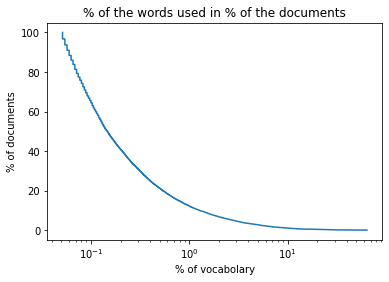

In [444]:
print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(10))
print("\nMost common 20 counted by word count total: ", cnt.most_common(10))

#print("Most common 50 counted by appearance in nr of reviews: ", cnt1.most_common(50))

vocab_size = len(cnt2)
sample_size = len(train_set)

x = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
y = [c/vocab_size * 100 for c in range(1, vocab_size+1)]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")

In [445]:
pd.set_option('display.max_colwidth', None)
train_set_processed.sample(10)

,review,rate,label,rev_lens_raw,rev_lens_words,processed
19327,"This is a review of 'Freddy Mercury The Untold Story,' theatrical release, Chicago Int. Film Festival, 2007 One of the phoniest, uninspired and most tedious biographical documentaries I have seen. If the film I saw in a movie theater was originally released on TV, I would plead with its producers and distributors to not fool a paying audience with the false promise of a cinematically worthy documentary feature. Even as a made-for-TV documentary, the sentimental piano solos accompanying interviewees sitting in front of flower arrangements in hotel rooms and the pompous, pseudo-literary narration rang more true of a sleepapedic bed Infomercial. The only redeeming aspects of this ""The Untold Story of Freddy Mercury"" -- or, uhm, was it ""The Untold Story of Princess Diana"" are the original concert, video and TV footage -- unabridged Freddy Mercury and Queen. Testimonial interviews with irrelevant eye witnesses with insights, such as: ""He was a free spirit,"" (really.. I thought Freddy Mercury was a company man...) belittle those Freddy testimonials, by Brian May or Montserrat Caballe that shed new and affectionate light into Mercury's complex life and character. And... what up with the Harry Potter-like boarding school segments? How did the interview with the first girl-crush (""...who now works in a travel agency"") and members of Freddy's first school band contribute to what I really want to know about Mercury? Vital milestones of his personal life, his sexuality, his artistic style and growth, Queen, the band remain unexplored. These filmmakers don't ask a single, provocative question, nor do they engage in independent or visionary research of their subject, instead delivering a tedious montage of politely clean and vastly empty comments about an enigmatic and brilliant rock legend, who doesn't deserve to be remembered by this History Channel biography your grandparents can doze off to on a Sunday night.",2,0,1932,304,review freddy story theatrical release chicago film festival one phony uninspired tedious biographical documentary see film saw movie theater originally release tv would plead producer distributor fool pay audience false promise worthy documentary feature even madefortv documentary sentimental piano solo accompany interviewee sit front flower arrangement hotel room pompous narration ring true bed infomercial redeem aspect story freddy story princess diana original concert video tv footage freddy queen interview irrelevant eye witness insight free spirit really think freddy company man freddy brian may shed new affectionate light complex life character harry board school segment interview first work travel agency member freddy first school band contribute really want know vital milestone personal life sexuality artistic style growth queen band remain unexplored filmmaker ask single provocative question engage independent visionary research subject instead deliver tedious montage politely clean vastly empty comment enigmatic brilliant rock legend deserve remember history channel biography grandparent doze sunday night
730,"The only time I have seen this movie was when I was 10 years old. I have remembered it all of these years as I couldn't sleep for a week or more after seeing it. It just absolutely rattled me. I was on vacation with my aunts in Ft. Worth, Texas and I will never forget it. Now, 48 years later, my daughter is trying to get a copy of this for me to view as an adult. It has taken a lot of research to find out what movie it was but I always remembered that Barbara Stanwyck was in it and finally was able to get the name and reviews on it. I very much enjoyed it, but it gave me quite a scare! Jaqui",10,1,598,127,time see movie year old remember year could sleep week see absolutely rattle vacation aunt ft worth texas never forget year late daughter try get copy view adult take lot research find movie always remember barbara stanwyck final

In [446]:
# Get the IDF values and VOCAB vector
vectorizer = TfIdfVectorizer(train_set_processed)
idfs = vectorizer.idfs
vocab = vectorizer.vocab

In [447]:
# Vectorizing train set and test set
X_train = vectorizer.tf_idf_vectorize_all(train_set_processed)

X_test = vectorizer.tf_idf_vectorize_all(test_set_processed)

X_valid = vectorizer.tf_idf_vectorize_all(valid_set_processed)

Y_train = train_set_processed['label'].to_numpy()

Y_test = test_set_processed['label'].to_numpy()

Y_valid = valid_set_processed['label'].to_numpy()

In [448]:
index = random.randint(0, len(train_set))
with np.printoptions(threshold=np.inf):
    print(X_train[index])
    print(Y_train[index])
train_set.loc[index, 'label']

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          6.06865419
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

0

## 2. Set up genetic algorithm


### 2.1 Classifier
There are a lot of classifiers. I haven't any experience in most of them, just a little familiar with Neural Network thus this is what I did choose.

The acitecture:
len(vector) input Relu() --> 64 nodes --> softmax() --> output

In [449]:
class Classifier:
    def __init__(self, idfs, vocab):
        self.idfs = idfs
        self.vocab = vocab
        self.ws_1 = 0
        self.ws_2 = 0
        self.ws_3 = 0
        self.ws_4 = 0
        self.np_predictor = np.vectorize(lambda vec: self.predict(vec))
        self.hn_1 = 0
        self.hn_2 = 0
        self.hn_3 = 0
        self.in_vector = 0

    # Initializing weights
    def init_weights(self):
        self.ws_1 = np.random.rand(self.in_vector, self.hn_1) - 0.5
        self.ws_2 = np.random.rand(self.hn_1, self.hn_2) - 0.5
        self.ws_3 = np.random.rand(self.hn_2, self.hn_3) - 0.5
        self.ws_4 = np.random.rand(self.hn_3, 2) - 0.5
        return self.ws_1, self.ws_2, self.ws_3, self.ws_4
        
    def set_weights(self, ws_1, ws_2, ws_3, ws_4):
        self.ws_1 = ws_1
        self.ws_2 = ws_2
        self.ws_3 = ws_3
        self.ws_4 = ws_4
    
    def set_hidden_nodes(self, in_vector, hn_1, hn_2, hn_3):
        self.hn_1 = hn_1
        self.hn_2 = hn_2
        self.hn_3 = hn_3
        self.in_vector = in_vector

    def relu(self, x):
        return (x > 0) * x
    
    def relu_grad(self, x):
        return x > 0
    
    def sigmoid(self, x):
        from scipy import special
        return special.expit(x)
    
    def sigmoid_grad(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))
    
    def softmax(self, x):
        import numpy as np
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
        
    def train_with_SGD(self, epochs, lr, x, y):
        error_list = list()
        mse_list = list()
        
        for n in range(epochs):
            for i in range(x.shape[0]):
                l_in = x[i:i+1]
                l_o, l_4, l_3, l_2, l_1, s_1 = self.predict(l_in, True)           
                
                delta_2 = l_2 - y[i]
                delta_1 = delta_2.dot(self.ws_2.T) * self.relu_grad(l_1)
                
                self.ws_2 -= lr * (l_1.T.reshape(self.hn_1,1).dot(delta_2))
                self.ws_1 -= lr * (l_in.T.reshape(x.shape[1],1).dot(delta_1))

                error = delta_2**2
                    
                error_list.append(error[0][0])
            
            mse_list.append(sum(error_list) / x.shape[0])
            error_list = list()
        
        cel, output, acc = self.predict_whole_set(x, y)
        
        return mse_list, cel, output, acc
                

    def cross_entropy(self, p, y):
        import numpy as np
        return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
    
    def predict(self, x, get_all=False):
        #forward pass/prediction
        layer_1 = self.relu(x.dot(self.ws_1))
        layer_2 = self.relu(layer_1.dot(self.ws_2))
        layer_3 = self.relu(layer_2.dot(self.ws_3))
        layer_4 = layer_3.dot(self.ws_4)
        layer_out = self.softmax(layer_4)
        if get_all:
            return layer_out, layer_4, layer_3, layer_2, layer_1
        else:
            return layer_out
    
    def get_accuracy(self, y, p):
        acc = np.sum((y == np.argmax(p, axis=1))) / len(y)
        return acc
    
    
    
    def predict_whole_set(self, x, y, get_acc = True):
        output = np.apply_along_axis(self.predict, 1, x)
        cel = self.cross_entropy(output, y)
        if get_acc:
            acc = self.get_accuracy(y, output)
        if get_acc:
            acc = self.get_accuracy(y, output)
            return cel, output, acc
        else:
            return cel, output
    

        

#### PyTorch test

In [515]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

In [516]:
# Training function

def training(num_epochs, model, optimizer, criterion, train_loader):
    results = list()
    accuracies = list()
    valid_results = list()

    #model.float()
    for ep in range(num_epochs):
        running_loss = 0
        valid_loss = 0
        total = 0
        correct = 0
        model.train() # Set model into training mode
        for batch in train_loader:
            # We extract the images and labels from the batch
            vector = batch[:, :len(vocab)]
            labels = batch[:, len(vocab)]
            labels = torch.tensor(labels, dtype=torch.long)
            # This will prevent the gradient descents from the previous batches to accumulate. Without this the weight will get updated with the sum of
            # all previos gradient descents, instead of the gradient descents on the current batch.
            optimizer.zero_grad() 
            output = model(vector) # prediction / output from the model

            loss = criterion(output, labels)  # We calculate the loss here
            loss.backward() # Computes the derivative of the loss using backpropagation.
            optimizer.step() # We update the weights

            running_loss += loss.item() # Sum the loss here
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        else:
            results.append(running_loss / len(train_loader))  # We append the mean loss into a list
            accuracies.append(correct / total)
    
#     # Validation part
#     model.eval()
#     with torch.no_grad(): # This will prevent calculation of gradient descents
#         for batch in valid_loader:
#             images = batch[:, :784]
#             labels = batch[:, 784]
#             valid_output = model(images) # Prediciton
#             loss = criterion(valid_output, labels.long()) # Calculation of loss
#             valid_loss += loss.item() # Sum the loss
#         else:
#             valid_results.append(valid_loss / len(valid_loader)) # Here we calculate the mean loss
    return results, accuracies

In [517]:
learning_rate = 0.01

num_epochs = 30

criterion = nn.CrossEntropyLoss()



In [518]:
train_torch = np.c_[X_valid, Y_valid]

train_torch = torch.from_numpy(train_torch)
train_torch = torch.tensor(train_torch, dtype=torch.float)

<ipython-input-518-65a7058db3da>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_torch = torch.tensor(train_torch, dtype=torch.float)


In [519]:
train_loader = torch.utils.data.DataLoader(train_torch, batch_size=1, shuffle=True)

In [520]:
model = nn.Sequential(nn.Linear(len(vocab), 8),
                      nn.ReLU(),
                      nn.Linear(8, 8),
                      nn.ReLU(),
                      nn.Linear(8,2)
                     )

optimizer = optim.SGD(model.parameters(), lr = learning_rate)


        
        
    

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0])
tensor([[-0.4299, -0.0343]], grad_fn=<AddmmBackward>)
tensor(0.9104, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-0.4151, -0.0777]], grad_fn=<AddmmBackward>)
tensor(0.5386, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-0.3480, -0.0493]], grad_fn=<AddmmBackward>)
tensor(0.5549, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-0.4539, -0.0079]], grad_fn=<AddmmBackward>)
tensor(0.4948, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0])
tensor([[-0.4082, -0.0462]], grad_fn=<AddmmBackward>)
tensor(0.8905, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0])
tensor([[-0.3878, -0.0167]], grad_fn=<AddmmBackward>)
tensor(0.8958, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-0.3532, -0.0391]], grad_fn=<AddmmBackward>)

<ipython-input-520-90e65588f1f2>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


In [521]:
sgd_results, accuracies = training(num_epochs, model, optimizer, criterion, train_loader)

<ipython-input-516-e33ff79a67a8>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


In [522]:
len(sgd_results)

30

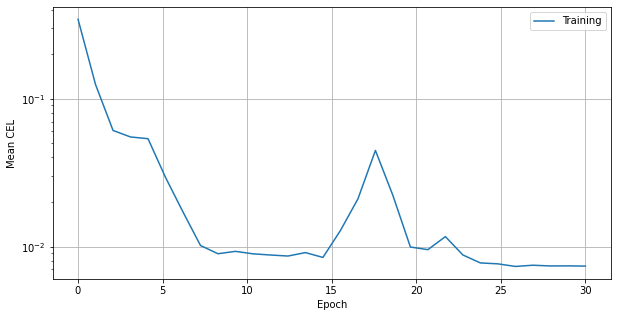

30

In [523]:
x_axis = np.linspace(0, num_epochs, num_epochs)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, sgd_results, label='Training')
ax.set_ylabel("Mean CEL")
ax.set_xlabel("Epoch")
ax.grid()

ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend()

plt.show()
len(sgd_results)

In [526]:
print(sgd_results[0])
print(sgd_results[-1])
print(accuracies[0])
print(accuracies[-1])

0.34342260895478366
0.007378576849851963
0.5
0.5


In [525]:
i = 0
model.eval()
for batch in train_loader:
        vector = batch[:, :len(vocab)]
        print(vector)
        labels = batch[:, len(vocab)]
        labels = torch.tensor(labels, dtype=torch.long)
        print(labels)
        # This will prevent the gradient descents from the previous batches to accumulate. Without this the weight will get updated with the sum of
        # all previos gradient descents, instead of the gradient descents on the current batch.
        optimizer.zero_grad() 
        output = model(vector) # prediction / output from the model
        print(output)

        loss = criterion(output, labels)  # We calculate the loss here
        print(loss)
        i += 1
        if i > 10:
            break

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0])
tensor([[  6.8160, -10.7132]], grad_fn=<AddmmBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[ 0.2157, -1.0086]], grad_fn=<AddmmBackward>)
tensor(1.4820, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-8.4777,  7.1581]], grad_fn=<AddmmBackward>)
tensor(1.1921e-07, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0])
tensor([[ 12.5642, -21.3027]], grad_fn=<AddmmBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-9.9456,  8.5726]], grad_fn=<AddmmBackward>)
tensor(0., grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-6.6096,  5.1429]], grad_fn=<AddmmBackward>)
tensor(7.8678e-06, grad_fn=<NllLossBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1])
tensor([[-5.7522,  4.8340]], grad_fn=<AddmmBackward>)

<ipython-input-525-3b27fece13ec>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


#### PyTorch Logistic Regression

In [460]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [461]:
train_loader = torch.utils.data.DataLoader(train_torch, batch_size=1, shuffle=True)

In [462]:
epochs = 15
input_dim = len(vocab)
output_dim = 2
lr_rate = 0.01

model = LogisticRegression(input_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

criterion = torch.nn.CrossEntropyLoss()

In [463]:
lr_results = list()
for epoch in range(epochs):
    running_loss = 0
    model.train()
    i = 0
    for batch in train_loader:
        vector = batch[:, :len(vocab)]
        labels = batch[:, len(vocab)]
        labels = torch.tensor(labels, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(vector)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # Sum the loss here
    else:
        lr_results.append(running_loss / len(train_loader))  # We append the mean loss into a list

print(lr_results[0])
print(lr_results[-1])

<ipython-input-463-74b774eeb8ea>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


1.216426999048443
0.0006053260079887186


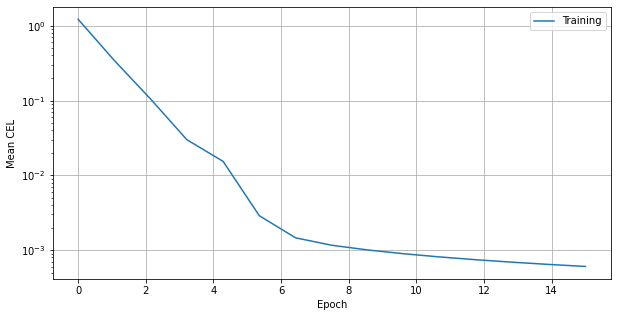

In [464]:
x_axis = np.linspace(0, epochs, epochs)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, lr_results, label='Training')
ax.set_ylabel("Mean CEL")
ax.set_xlabel("Epoch")
ax.grid()

ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend()

plt.show()


In [465]:
# Initialize classifier
classifier = Classifier(idfs, vocab)

In [466]:
classifier.set_hidden_nodes(len(vocab), 8, 8, 8)
classifier.init_weights()
cel_pre, output, acc_pre = classifier.predict_whole_set(X_valid, Y_valid)
print(cel_pre)
print(acc_pre)

print(sum(np.argmax(output, axis=1)))

1.0546078698147414
0.48946666666666666
2289


In [467]:
# Training with SGD
# mse, cel, output, acc = classifier.train_with_SGD(40, 0.1, X_train, Y_train)

In [468]:
# Test training
# x = np.array([[1,0,1], 
#                          [0,1,1], 
#                          [0,0,1], 
#                          [1,1,1], 
#                          [0,1,1], 
#                          [1,0,1]], dtype=np.float64)

# y = np.array([0, 1, 0, 1, 1, 0], dtype=np.int64)

# classifier.init_weights(3)

# mse, cel, p, acc = classifier.train_with_SGD(1, 0.1, x, y)

# cel, p, acc = classifier.predict_whole_set(x, y)

# print(cel)
# print(acc)
# print(sum(np.argmax(output, axis=1)))
# p

In [469]:
# %%time
# # Test run classifier
# classifier.init_weights()
# cel_pre, output1, acc_pre = classifier.predict_whole_set(X_train, Y_train)
# print(cel_pre, acc_pre)



### 2.2 Chromosome
It's just some weights that'll be used for classification

In [470]:
class Chromosome:
    # x_pos and y_pos are the features of our chromosome
    def __init__(self, ws_1, ws_2, ws_3, ws_4):
        self._fitness = 0
        self._ws_1 = ws_1
        self._ws_2 = ws_2
        self._ws_3 = ws_3
        self._ws_4 = ws_4
    
    # Getters and setters
    @property
    def ws_1(self):
        return self._ws_1
    
    @ws_1.setter
    def ws_1(self, value):
        self._ws_1 = value
    
    @property
    def ws_2(self):
        return self._ws_2
    
    @ws_2.setter
    def ws_2(self, value):
        self._ws_2 = value
    
    @property
    def ws_3(self):
        return self._ws_3
    
    @ws_3.setter
    def ws_3(self, value):
        self._ws_3 = value
    
    @property
    def ws_4(self):
        return self._ws_4
    
    @ws_4.setter
    def ws_4(self, value):
        self._ws_4 = value
    
    @property
    def fitness(self):
        return self._fitness
    
    @fitness.setter
    def fitness(self, value):
        self._fitness = value
    
    def __lt__(self, other):
        return self.fitness < other.fitness

    def __le__(self, other):
        return self.fitness <= other.fitness
    
    def __eq__(self, other):
        return self.fitness == other.fitness
    
    def __ne__(self, other):
        return self.fitness != other.fitness
    
    def __ge__(self, other):
        return self.fitness >= other.fitness
    
    def __gt__(self, other):
        return self.fitness > other.fitness
    
    def assign_fitness(self, classifier, x, y):
        import math
        classifier.set_weights(self.ws_1, self.ws_2, self.ws_3, self.ws_4)
        loss, _, acc = classifier.predict_whole_set(x, y, True)
        self.fitness = 1 / loss #0 if loss <= 0 or loss == float('inf') else -math.log(1 / loss)
    
    # produce a new offspring from 2 parents
    def crossover(self, other):
        r = 5
        
        min_mat_1 = np.minimum(self.ws_1, other.ws_1)
        max_mat_1 = np.maximum(self.ws_1, other.ws_1)
        min_mat_2 = np.minimum(self.ws_2, other.ws_2)
        max_mat_2 = np.maximum(self.ws_2, other.ws_2)
        min_mat_3 = np.minimum(self.ws_3, other.ws_3)
        max_mat_3 = np.maximum(self.ws_3, other.ws_3)
        min_mat_4 = np.minimum(self.ws_4, other.ws_4)
        max_mat_4 = np.maximum(self.ws_4, other.ws_4)
        
        ws_1 = np.random.uniform(min_mat_1-r, max_mat_1+r)
        ws_2 = np.random.uniform(min_mat_2-r, max_mat_2+r)
        ws_3 = np.random.uniform(min_mat_3-r, max_mat_3+r) 
        ws_4 = np.random.uniform(min_mat_4-r, max_mat_4+r) 
        
        offspring = Chromosome(ws_1, ws_2, ws_3, ws_4)
        return offspring

    # mutate the individual
    def mutate(self):
        np.random.shuffle(self.ws_1)
        self.ws_1 = self.ws_1 + np.random.uniform(-5, 5, size=self.ws_1.shape)
        np.random.shuffle(self.ws_2)
        self.ws_2 = self.ws_2 + np.random.uniform(-5, 5, size=self.ws_2.shape)
        np.random.shuffle(self.ws_3)
        self.ws_3 = self.ws_3 + np.random.uniform(-5, 5, size=self.ws_3.shape)
        np.random.shuffle(self.ws_4)
        self.ws_4 = self.ws_4 + np.random.uniform(-5, 5, size=self.ws_4.shape)
        return
    

    



### 2.3 Genetic Algorithm Engine

Here I have divided the population in two: elite and population.
Elite contains the population with highest fitness. This is to make sure if we find a very fit chromosome we don't lose it again because of cross overs or mutations.

And we make the mutations first. We make mutations on the least fit chromosomes. Mutations are here are nothing more than just randomly generating a new chromosome.




In [471]:
class GAEngine:
    def __init__(self, classifier):
        self._population = []
        self._generations = 0
        self._classifier = classifier
        self.elite = []
        self.nr_of_elites = 0
        self.to_mutate = []

    def make_initial_population(self, population_size):       
        for i in range(population_size):
            ws_1, ws_2, ws_3, ws_4 = self.classifier.init_weights()
            self.population.append(Chromosome(ws_1, ws_2, ws_3, ws_4))

        
    @property
    def generations(self):
        return self._generations
    
    @generations.setter
    def generations(self, g):
        self._generations = g
    
    @property
    def population(self):
        return self._population
    
    @population.setter
    def population(self, p):
        self._population = p
    
    @property
    def classifier(self):
        return self._classifier
    
    @classifier.setter
    def classifier(self, cl):
        self._classifier = cl
    
    # selection code goes here...
    def do_crossover(self, elite_crossover_rate):
        import random
        population_size = len(self.population)
        
                
        # Here we combine elitism selection with roulette wheel
        # We carry some of the most fit over to the next generation.
        # We do cross over with both the elite and other population
        # Then we use roulette wheel because we want diversity too.
        # We want diversity because it's hard to predict optimal weights
        
        no_of_elite_crossovers = int(elite_crossover_rate * population_size)
        
        other_offspring = population_size - no_of_elite_crossovers

        new_generation = list()
        
        # Offsprings from the elite
        for i in range(no_of_elite_crossovers):
            parent1, parent2 = random.choices(self.elite, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        # Weighted random choice
        fitness_values = [x.fitness**2 for x in self.population]
        
        # Offsprings from other population
        for i in range(other_offspring):
            parent1, parent2 = random.choices(self.population, weights=fitness_values, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        # The population is the new generation
        self.population = new_generation
        return
    
    
    def do_mutation(self, no_of_mutation, x, y):
        for i in range(no_of_mutation):
            self.population[-i-1].mutate()
            self.population[-i-1].assign_fitness(self.classifier, x, y)
    
    
    # fitness calculation goes here...
    def assign_fitness(self, x, y):
        for ch in self.population:
            ch.assign_fitness(self.classifier, x, y)
        self.population = sorted(self.population, reverse=True)
        self.update_elite()
        return
    
    def get_population(self):
        return self.population
    
    def update_elite(self):
        if len(self.elite) == 0:
            self.elite = self.population[-self.nr_of_elites:]
            self.elite = sorted(self.elite, reverse=True)
            return
        i = 0
        j = 0
        while i < self.nr_of_elites and j < len(self.population):
            if self.elite[i] < self.population[j]:
                self.elite[i] = self.population[j]
                i += 1
                j += 1
            else:
                i += 1
        
        self.elite = sorted(self.elite, reverse=True)

    
    def get_best_chromosome(self):
        return self.elite[0]
    
    # TRAINING ROUTINE
    def training_routine(self, init_population, nr_of_generations, 
                        nr_of_mutation, nr_of_elites, elite_crossover_rate, x, y):
        self.make_initial_population(init_population)
        self.generations = nr_of_generations
        self.nr_of_elites = nr_of_elites
        
        cels = list()


        for i in range(self.generations):
            self.assign_fitness(x, y)
            self.update_elite()
            cels.append(self.elite[-1].fitness)
            
            self.do_mutation(nr_of_mutation, x, y)
            self.update_elite()
            
            self.do_crossover(elite_crossover_rate)
            
            

        # Assign fitness last time before getting the best chromosome
        self.assign_fitness(x, y)
        self.update_elite()
        cels.append(self.get_best_chromosome().fitness)
        return self.get_best_chromosome(), cels


In [ ]:
%%time
# Here I run the GA engine
classifier = Classifier(idfs, vocab)
classifier.set_hidden_nodes(len(vocab), 16, 8, 8)

ga = GAEngine(classifier)
gens = 10
ch, cels = ga.training_routine(10, gens, 8, 3, 0.2, X_test, Y_test)
cels


In [ ]:
# for i in range(3):
#     print("pop", ga.population[i].fitness)
#     print("elite", ga.elite[i].fitness)

In [ ]:
# Plotting increase of fitness in training
x = np.linspace(0, gens+1, gens+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, cels, label='fitness')

plt.xlabel("Generations")
plt.ylabel("fitness")
plt.title("Change of fitness (fitness = accuracy")

plt.grid()
plt.show()


## 3. Validation

In [ ]:
classifier.set_weights(ch.ws_1, ch.ws_2, ch.ws_3, ch.ws_4)
cel_post, output_post, acc_post = classifier.predict_whole_set(X_valid, Y_valid)

In [ ]:
print("Accuracy before training: ", acc_pre)
print("Accuracy after training: ", acc_post)
print("CEL before training", cel_pre)
print("CEL after training", cel_post)

In [ ]:
print(sum(np.argmax(output_post, axis=1)))

In [103]:
arr1 = [1,2,3]
arr2 = [4,5]
arr3 = [7,8, 9,10]

nparr3 = np.array([arr1, arr2, arr3])
nparr = np.array([[1,2,3],[3,4,5],[4,5,6]])
nparr2 = np.array([[1, 3],[3, 4],[3,4],[3,2],[2,1],[9,3]])

np.argmax(nparr2, axis=1)
nparr2

<ipython-input-103-b4c45037dd8a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nparr3 = np.array([arr1, arr2, arr3])


array([[1, 3],
       [3, 4],
       [3, 4],
       [3, 2],
       [2, 1],
       [9, 3]])

In [ ]:
np.random.rand(3, 2)

In [ ]:
starr = np.array(["thIs is Good", "this is BAD", "this is NOT so good"])

class test:
    def __init__(self):
        return
    
    def func(self, x, y):
        x = x + y
        return str.lower(x)
    

t = test()

vecfunc = np.vectorize(t.func)

vecfunc(starr, "aaa")

In [ ]:
np.char.split(starr)

In [ ]:
yy = [0, 1, 1]
zz = [[0.5, 0.9],[0.5, 0.9], [0.5, 0.9]]
np.eye(2)[yy]
#-np.nan_to_num(yy*np.log(zz))

In [ ]:
-np.log(0.9)

In [ ]:
x = "aaa"
y = x + "bb"
y

In [ ]:
%%time
" ".join(train_set['reviews'].values)

In [459]:
processor

NameError: name 'processor' is not defined

In [828]:
np.exp(1)

2.718281828459045

In [61]:
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

x_train

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.]], dtype=float32)